In [67]:
#data management imports
import numpy as np
import pandas as pd

#plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#modeling imports
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score

from IPython.display import clear_output
import time

### Top 10 species in Northern/Southern region

In [2]:
spe = ['loblolly pine','sweetgum','red maple','slash pine','yellow-poplar',
      'balsam fir','sugar maple','quaking aspen','northern white-cedar','paper birch']

### Load tree data, clean data and prepare features

In [3]:
#load trees data
trees = pd.read_csv('county_tree_temp_dwp_prcp_KT_NS10.csv')
trees = trees.sort_values(['state_code','county_code','species','year'])
trees = trees.reset_index(drop = True)

#clean data
trees = trees.drop(trees.loc[(trees.volume == 0) | (trees.height == 0)].index)

le = LabelEncoder()
trees['speciesID'] = le.fit_transform(trees.species)
trees['volume'] = trees['volume'] / trees['number_trees']
trees['Biomass'] = trees['Biomass'] / trees['number_trees']
trees['height'] = trees['height'] / trees['number_trees']
trees['diameter'] = trees['diameter'] / trees['number_trees']
trees['Density'] = trees['Biomass']/trees['volume']
trees['logMass'] = np.log(trees['Biomass'])
trees['logvolume'] = np.log(trees['volume'])
trees['logdensity'] = np.log(trees['Density'])
trees = trees.drop(trees.loc[trees.Density > 100].index)

species = trees.species.unique()

### Make a few interesting plots

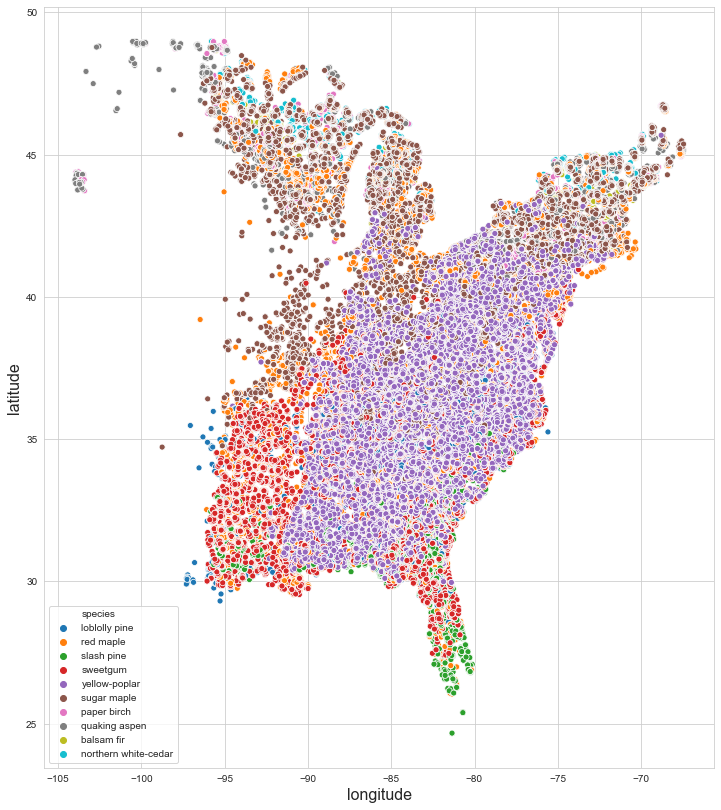

In [4]:
xf = 'longitude'
yf = 'latitude'
plt.figure(figsize=(12,14))
sns.scatterplot(data=trees.loc[trees.species.isin(spe)],x=xf,y=yf,hue="species")
#sns.scatterplot(data=trees.loc[trees.species.isin(species[::3])],x=xf,y=yf,hue="species")

plt.xlabel(xf, fontsize=16)
plt.ylabel(yf, fontsize=16)

plt.show()

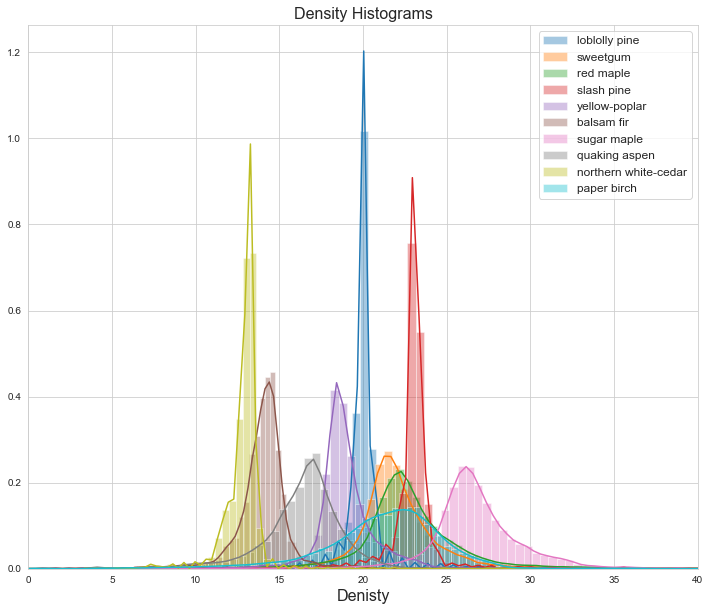

In [5]:
plt.figure(figsize=(12,10))
for i,s in enumerate(spe):
    sns.distplot(trees.loc[(trees.species == s) & (trees.Density < 50)]['Density'],
                 bins = 100,label = s)
plt.legend(fontsize = 12)
plt.xlabel('Denisty',fontsize = 16)
plt.title('Density Histograms',fontsize = 16)
plt.xlim((0,40))
plt.show()

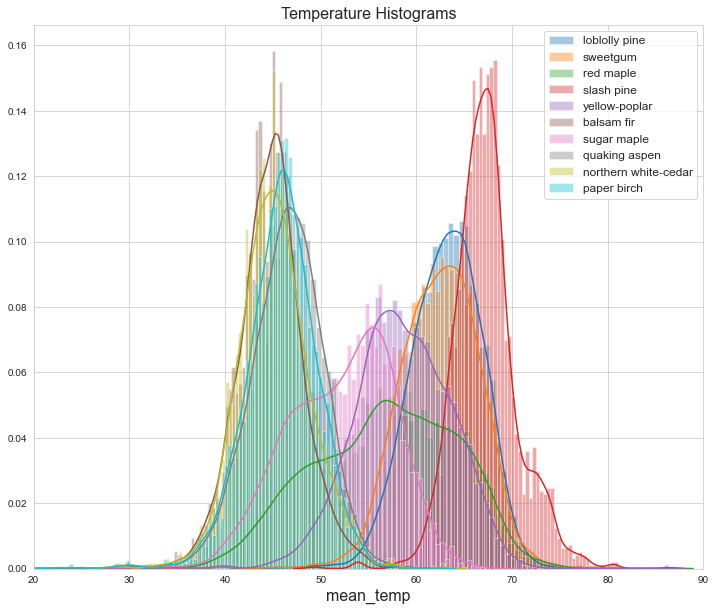

In [87]:
plt.figure(figsize=(12,10))
for i,s in enumerate(spe):
    sns.distplot(trees.loc[(trees.species == s) & (trees.Density < 50)]['mean_temp'],
                 bins = 100,label = s)
plt.legend(fontsize = 12)
plt.xlabel('mean_temp',fontsize = 16)
plt.title('Temperature Histograms',fontsize = 16)
plt.xlim((20,90))
plt.show()

## Classification using Neural Network MLP

In [4]:
scaler = StandardScaler()
mlp = MLPClassifier(hidden_layer_sizes=(100,),max_iter=1000)

In [95]:
features = ['latitude','longitude','Density',
            'mean_temp','height','logdensity',
            'Biomass','diameter','mean_prcp',
            'mean_dwp','volume','logMass',
            'logvolume']

In [92]:
trees10 = trees.loc[trees.species.isin(spe)].copy() #top 10 trees
train,test = train_test_split(trees10,test_size=.1,shuffle=True,stratify = trees10.speciesID,random_state = 42)

#### Look at ideal number of features

In [45]:
runs = [4,6,8,9,13] #setup loop ranges for features (impractictical to do 1-13)
t0 = time.perf_counter()
y = train.speciesID
score = np.zeros((5,3))
for i,r in enumerate(runs):
    clear_output()
    print(f'Now working on {i}')
    f = features[:r]
    X = train[f].copy()
    score[i,:] = cross_val_score(mlp, X, y, cv=3, n_jobs = -1)
clear_output()
t1 = time.perf_counter()
print(f'Runtime: {t1-t0} seconds')
score.mean(axis = 1)

Runtime: 202.9739658999997 seconds


array([0.60559478, 0.63168721, 0.62811063, 0.60415124, 0.71993927])

#### look at ideal number of layers

In [53]:
t0 = time.perf_counter()
layer = np.arange(1,10,1)
score = np.zeros((layer.size,3))
y = train.speciesID
for i,l in enumerate(layer):
    mlp = MLPClassifier(hidden_layer_sizes=(l,),max_iter=1000)
    clear_output()
    print(f'Now working on {i}')
    f = features[:13]
    X = train[f].copy()
    score[i,:] = cross_val_score(mlp, X, y, cv=3, n_jobs = -1)
clear_output()
t1 = time.perf_counter()
print(f'Runtime: {t1-t0} seconds')
score.mean(axis = 1)

Runtime: 668.4076430000023 seconds


array([0.25992055, 0.49278695, 0.51041884, 0.63222524, 0.68842428,
       0.6981253 , 0.72301903, 0.72824587, 0.73777964])

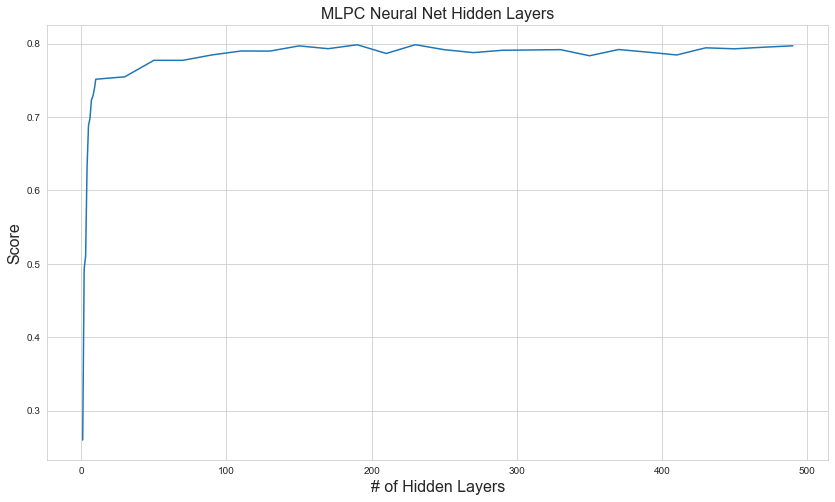

In [60]:
LayerScore = [0.25992055, 0.49278695, 0.51041884, 0.63222524, 0.68842428,
              0.6981253 , 0.72301903, 0.72824587, 0.73777964,0.75145306, 
              0.75474249, 0.77719702, 0.77719702, 0.78455642,0.7899087 , 
              0.7897972 , 0.79687783, 0.79304481, 0.79841104,0.78653565, 
              0.79850861, 0.79167886, 0.78770646, 0.79089832,0.79130253, 
              0.79176249, 0.78342742, 0.79191581, 0.78833368,0.78450066, 
              0.7942435 , 0.79289149, 0.79509373, 0.7969754 ]
layer  = [1, 2, 3, 4, 5, 6, 7, 8, 9,
          10,  30,  50,  70,  90, 110, 130, 150, 170, 
          190, 210, 230, 250,270, 290, 310, 330, 350,
          370, 390, 410, 430, 450, 470, 490]
plt.figure(figsize = (14,8))
plt.plot(layer,LayerScore)
plt.ylabel('Score',fontsize = 16)
plt.xlabel('# of Hidden Layers',fontsize = 16)
plt.title('MLPC Neural Net Hidden Layers',fontsize = 16)
plt.show()

#### Looking at if standard scaler is worth using or not (hint, it is!)

In [61]:
mlp = MLPClassifier(hidden_layer_sizes=(100,),max_iter=1000)

t0 = time.perf_counter()
y = train.speciesID
f = features[:13]
X = train[f].copy()
score = cross_val_score(mlp, X, y, cv=3, n_jobs = -1)

t1 = time.perf_counter()
print(f'Runtime: {t1-t0} seconds')
print(score.mean())

t0 = time.perf_counter()
y = train.speciesID
f = features[:13]
X = train[f].copy()
X = scaler.fit_transform(X)
score = cross_val_score(mlp, X, y, cv=3, n_jobs = -1)

t1 = time.perf_counter()
print(f'Runtime: {t1-t0} seconds')
print(score.mean())

Runtime: 408.84694540000055 seconds
0.7833159105164124
Runtime: 174.20048910000332 seconds
0.8393058749738658


In [96]:
mlp = MLPClassifier(hidden_layer_sizes=(100,),max_iter=1000)
scaler = StandardScaler()

t0 = time.perf_counter()
y = train.speciesID
X = train[features].copy()
X = scaler.fit_transform(X)

mlp.fit(X,y)
t1 = time.perf_counter()
print(f'Runtime: {t1-t0} seconds')

Runtime: 228.9641072000013 seconds


In [97]:
print(mlp.score(X,y))
print(precision_score(y,mlp.predict(X), average = 'macro'))
print(recall_score(y,mlp.predict(X), average = 'macro'))
print(accuracy_score(y,mlp.predict(X)))

0.8511952052407833
0.8636078675316826
0.8502561766699379
0.8511952052407833


### Everything below here is not currently used, just bits and pieces of code from previous tests

In [182]:
spe5 = mlp.predict(x_test)
NN = pd.DataFrame(columns = ['speciesID','correct'])
NN['speciesID'] = y_test
NN['correct'] = mlp.predict(x_test) == y_test
NN = NN.reset_index(drop = True)

In [165]:
accpd = pd.DataFrame(columns = ['species','acc'])
for i,s in enumerate(spe):
    sid = le.transform([s])
    samp = NN.loc[NN.speciesID == sid[0]]
    acc = sum(samp['correct']) / len(samp)
    accpd.loc[i] = [s,acc]
accpd

,species,acc
0,loblolly pine,0.896970
1,sweetgum,0.739092
2,red maple,0.839286
3,slash pine,0.793103
4,yellow-poplar,0.896321


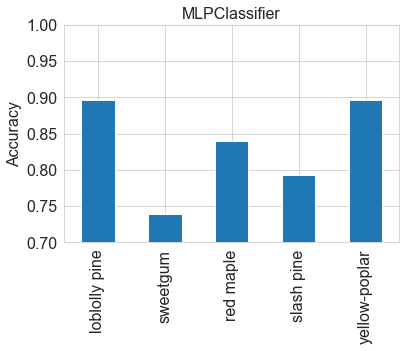

In [181]:
accpd.plot.bar(x='species', y='acc',fontsize = 16,legend = False)
plt.ylim((0.7,1))
plt.ylabel('Accuracy',fontsize = 16)
plt.xlabel('',fontsize = 16)
plt.title('MLPClassifier',fontsize = 16)
plt.show()